In [8]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import numpy as np
import joblib
import wandb
import os


from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import fbeta_score, precision_score, recall_score, accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.tree import DecisionTreeClassifier

from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import mnist
import tensorflow as tf

## Carregando o dataset

In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [4]:
samples, w, h = x_train.shape

print(f'{samples} in the training dataset with dimension {w}x{h}')

samples, w, h = x_test.shape

print(f'{samples} in the test dataset with dimension {w}x{h}')

60000 in the training dataset with dimension 28x28
10000 in the test dataset with dimension 28x28


## EDA

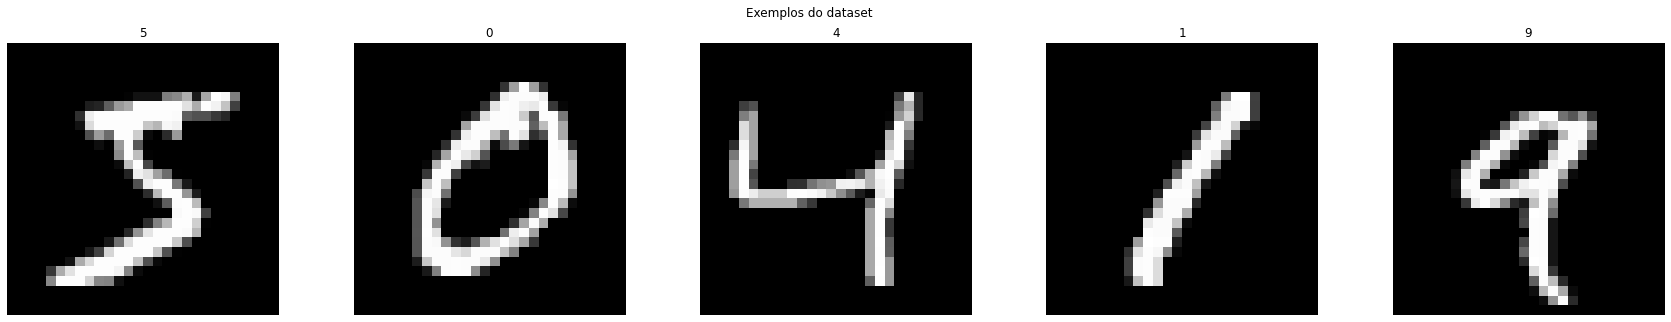

In [5]:
fig, ax = plt.subplots(ncols=5, figsize=(30, 5))

for idx, image in enumerate(x_train[:5]):

    ax[idx].imshow(image, cmap='gray')
    ax[idx].axis('off')

    ax[idx].set_title(f'{y_train[idx]}')

fig.suptitle('Exemplos do dataset')

plt.show()

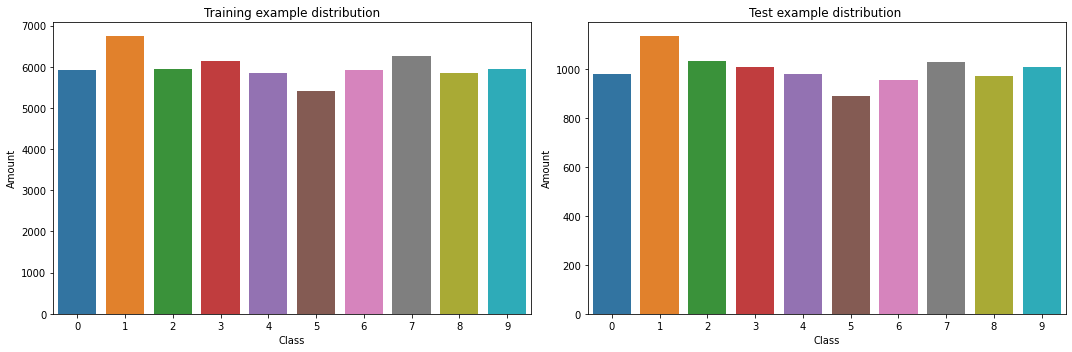

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

sns.countplot(x=y_train, ax=ax[0])
ax[0].set(
    title='Training example distribution',
    xlabel='Class',
    ylabel='Amount'
)

sns.countplot(x=y_test, ax=ax[1])
ax[1].set(
    title='Test example distribution ',
    xlabel='Class',
    ylabel='Amount'
)

plt.tight_layout()
plt.show()

## Modelo MLP Baseline

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

mlb = MultiLabelBinarizer()

y_train = mlb.fit_transform(y_train.reshape((-1,1)))

In [14]:
mlp = Sequential([
    Input(shape=(28,28)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.15),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

mlp.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

mlp.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_6 (Dense)             (None, 128)               100480    
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 118,282
Trainable params: 118,282
Non-tr

In [ ]:
history = mlp.fit(
    x_train, y_train,
    validation_split=0.1,
    batch_size=64,
    epochs=2000,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)

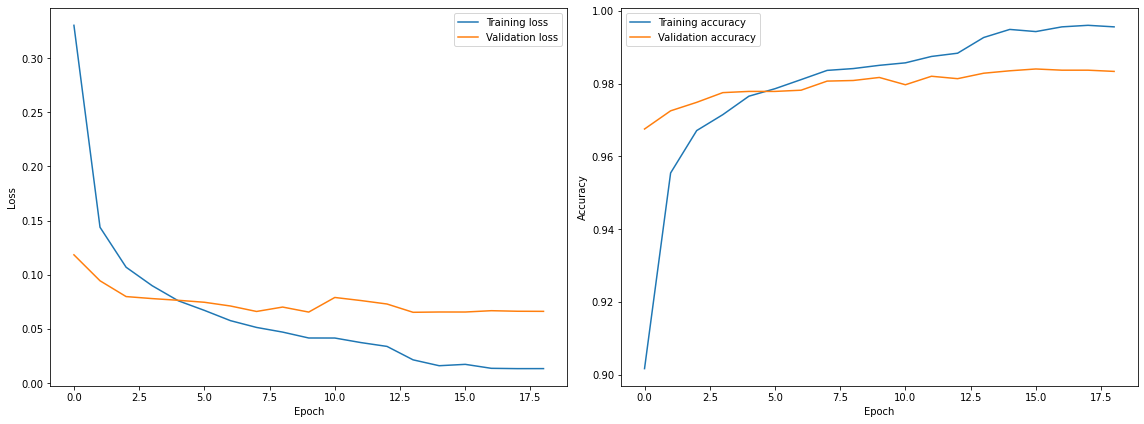

In [16]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')

ax[0].legend()
ax[0].set(
    ylabel='Loss',
    xlabel='Epoch'
)

ax[1].plot(history.history['acc'], label='Training accuracy')
ax[1].plot(history.history['val_acc'], label='Validation accuracy')

ax[1].set(
    ylabel='Accuracy',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [20]:
y_pred = [ np.argmax(pred) for pred in mlp.predict(x_test) ] 

In [22]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.98      0.99      0.98      1010
           4       0.99      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.99      0.98      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



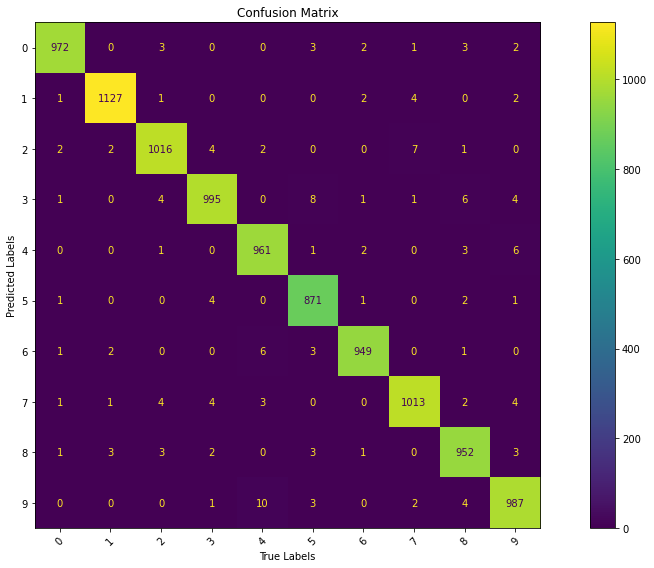

In [23]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test, labels=list(range(10))),
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Confusion Matrix',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

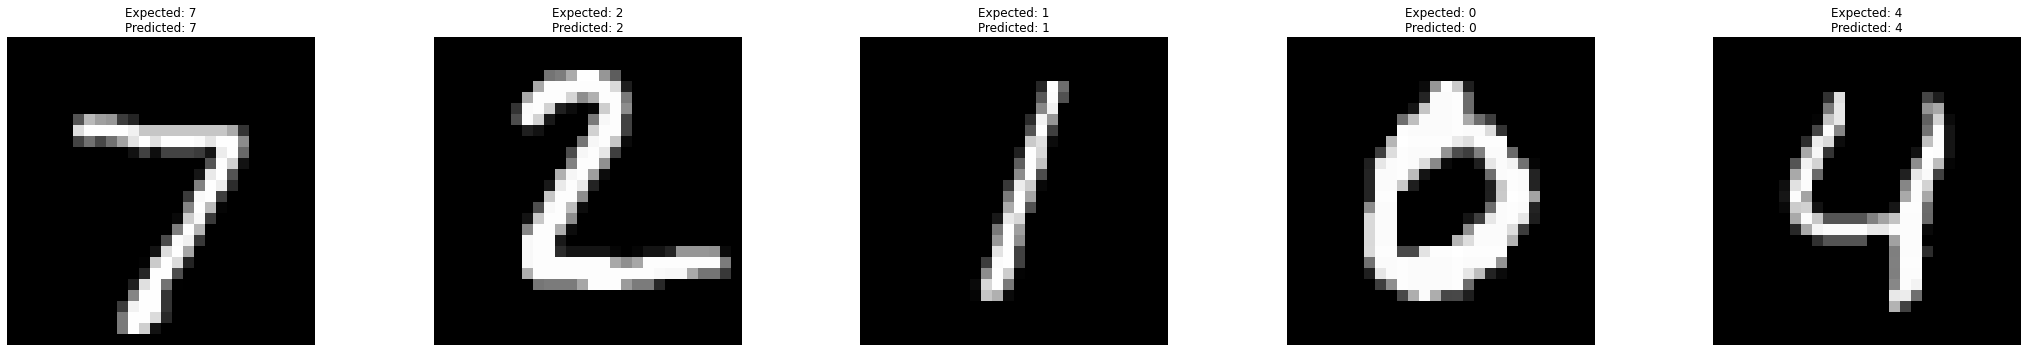

In [24]:
fig, ax = plt.subplots(ncols=5, figsize=(30, 5))

for idx, image in enumerate(x_test[:5]):

    ax[idx].imshow(image, cmap='gray')
    ax[idx].axis('off')

    ax[idx].set_title(f'Expected: {y_test[idx]}\nPredicted: {y_pred[idx]}')

plt.tight_layout()
plt.show()

## Modelo MLP com Autoencoder

In [25]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim   
        
        self.encoder = Sequential([
            Flatten(),
            Dense(1024, activation='relu'),
            Dropout(0.1),
            Dense(512, activation='relu'),
            Dropout(0.1),
            Dense(latent_dim, activation='relu'),
        ])

        self.decoder = Sequential([
            Dense(1024, activation='relu'),
            Dropout(0.1),
            Dense(512, activation='relu'),
            Dropout(0.1),
            Dense(784, activation='sigmoid'),
            Reshape((28, 28))
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [32]:
autoencoder = Autoencoder(100)

autoencoder.compile(
    loss='mse',
    optimizer='adam',
)

In [ ]:
history = autoencoder.fit(
    x_train, x_train,
    validation_split=0.1,
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)


In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')

ax[0].legend()
ax[0].set(
    ylabel='Loss',
    xlabel='Epoch'
)

ax[1].plot(history.history['acc'], label='Training accuracy')
ax[1].plot(history.history['val_acc'], label='Validation accuracy')

ax[1].set(
    ylabel='Accuracy',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
encoded_train_imgs = autoencoder.encoder(x_train).numpy()

encoded_test_imgs = autoencoder.encoder(x_test).numpy()
decoded_test_imgs = autoencoder.decoder(encoded_test_imgs).numpy()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 7))

for idx in range(5):
    # Original image
    ax[0][idx].imshow(x_test[idx], cmap='gray')

    ax[0][idx].set_title('Original image')
    
    ax[0][idx].axis('off')

    #Encoded imgae
    ax[1][idx].imshow(encoded_test_imgs[idx].reshape(10, 10), cmap='gray')

    ax[1][idx].set_title('Encoded image')
    
    ax[1][idx].axis('off')


    # Reconstructed image
    ax[2][idx].imshow(decoded_test_imgs[idx], cmap='gray')

    ax[2][idx].set_title('Reconstructed image')
    
    ax[2][idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

mlp.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

mlp.summary()

In [ ]:
history = mlp.fit(
    encoded_train_imgs, y_train,
    validation_split=0.1,
    batch_size=64,
    epochs=2000,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')

ax[0].legend()
ax[0].set(
    ylabel='Loss',
    xlabel='Epoch'
)

ax[1].plot(history.history['acc'], label='Training accuracy')
ax[1].plot(history.history['val_acc'], label='Validation accuracy')

ax[1].set(
    ylabel='Accuracy',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_pred = [ np.argmax(pred) for pred in mlp.predict(encoded_test_imgs) ] 

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test, labels=list(range(10))),
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Confusion Matrix',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))

for idx in range(5):
    # Original image
    ax[0][idx].imshow(encoded_test_imgs[idx].reshape(10, 10), cmap='gray')

    ax[0][idx].set_title(f'Expected: {y_test[idx]}\nPredicted: {y_pred[idx]}')
    
    ax[0][idx].axis('off')

    # Reconstructed image
    ax[1][idx].imshow(decoded_test_imgs[idx], cmap='gray')

    ax[1][idx].set_title('Reconstructed image')
    
    ax[1][idx].axis('off')

plt.tight_layout()
plt.show()


## Modelo com Autoencoders Convolucionais

In [ ]:
class Autoencoder(Model):
    def __init__(self, latent_dim):
        super(Autoencoder, self).__init__()
        
        self.latent_dim = latent_dim   
        
        self.encoder = Sequential([
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (2, 2), activation='relu', padding='same'),
            MaxPooling2D((2, 2)),
            BatchNormalization(),
            Conv2D(16, (2, 2), activation='relu', padding='same'),
            Conv2D(4, (2, 2), activation='relu', padding='same'),
            Conv2D(1, (2, 2), activation='relu', padding='same'),
            Flatten(),
            Dense(latent_dim, activation='relu'),
        ])

        self.decoder = Sequential([
            Dense(4, activation='relu'),
            Reshape((2, 2, 1)),
            Conv2D(4, (2, 2), activation='relu', padding='same'),
            Conv2D(16, (2, 2), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((7, 7)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            BatchNormalization(),
            UpSampling2D((2, 2)),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(32, (3, 3), activation='relu', padding='same'),
            Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)

        return decoded

In [ ]:
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

history = autoencoder.fit(
    x_train, x_train,
    validation_split=0.1,
    batch_size=32,
    epochs=100,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)

In [ ]:
encoded_train_imgs = autoencoder.encoder(x_train).numpy()

encoded_test_imgs = autoencoder.encoder(x_test).numpy()
decoded_test_imgs = autoencoder.decoder(encoded_test_imgs).numpy()

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=5, figsize=(15, 7))

for idx in range(5):
    # Original image
    ax[0][idx].imshow(x_test[idx], cmap='gray')

    ax[0][idx].set_title('Original image')
    
    ax[0][idx].axis('off')

    #Encoded imgae
    ax[1][idx].imshow(encoded_test_imgs[idx].reshape(10, 10), cmap='gray')

    ax[1][idx].set_title('Encoded image')
    
    ax[1][idx].axis('off')


    # Reconstructed image
    ax[2][idx].imshow(decoded_test_imgs[idx], cmap='gray')

    ax[2][idx].set_title('Reconstructed image')
    
    ax[2][idx].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
mlp = Sequential([
    Dense(128, activation='relu', input_shape=(100,)),
    Dropout(0.1),
    Dense(128, activation='relu'),
    Dropout(0.1),
    Dense(10, activation='softmax')
])

mlp.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['acc']
)

mlp.summary()

In [ ]:
history = mlp.fit(
    encoded_train_imgs, y_train,
    validation_split=0.1,
    batch_size=64,
    epochs=2000,
    shuffle=True,
    callbacks=[
        EarlyStopping(monitor='val_loss', patience=5),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)
    ]
)

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(16, 6))

ax[0].plot(history.history['loss'], label='Training loss')
ax[0].plot(history.history['val_loss'], label='Validation loss')

ax[0].legend()
ax[0].set(
    ylabel='Loss',
    xlabel='Epoch'
)

ax[1].plot(history.history['acc'], label='Training accuracy')
ax[1].plot(history.history['val_acc'], label='Validation accuracy')

ax[1].set(
    ylabel='Accuracy',
    xlabel='Epoch'
)

plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
y_pred = [ np.argmax(pred) for pred in mlp.predict(encoded_test_imgs) ] 

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    confusion_matrix(y_pred, y_test, labels=list(range(10))),
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Confusion Matrix',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(15, 5))

for idx in range(5):
    # Original image
    ax[0][idx].imshow(encoded_test_imgs[idx].reshape(10, 10), cmap='gray')

    ax[0][idx].set_title(f'Expected: {y_test[idx]}\nPredicted: {y_pred[idx]}')
    
    ax[0][idx].axis('off')

    # Reconstructed image
    ax[1][idx].imshow(decoded_test_imgs[idx], cmap='gray')

    ax[1][idx].set_title('Reconstructed image')
    
    ax[1][idx].axis('off')

plt.tight_layout()
plt.show()


## Otimizando o Modelo de Classificação

In [ ]:
from wandb.keras import WandbCallback
import wandb

wandb.login()

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.
x_train = np.reshape(x_train, (-1, 784))
x_test = np.reshape(x_test, (-1, 784))

In [ ]:
def Model():
    return Sequential([
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])
    
def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits)

    return loss_value

    
def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

In [ ]:
def train(
    train_dataset,
    val_dataset, 
    model,
    optimizer,
    loss_fn,
    train_acc_metric,
    val_acc_metric,
    epochs=10, 
    log_step=200, 
    val_log_step=50
):
  
    for epoch in range(epochs):
        print(f'\nEpoch # {epoch}')

        train_loss = []   
        val_loss = []

        # Iterate over the batches of the dataset
        for _, (x_batch_train, y_batch_train) in tqdm(enumerate(train_dataset), total=len(train_dataset)):
            loss_value = train_step(
                x_batch_train, y_batch_train, 
                model, optimizer, 
                loss_fn, train_acc_metric
            )

            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for _, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(
                x_batch_val, y_batch_val, 
                model, loss_fn, 
                val_acc_metric
            )
            
            val_loss.append(float(val_loss_value))
            
        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print(f'Training acc over epoch: {float(train_acc):.3f}')

        val_acc = val_acc_metric.result()
        print(f'Validation acc: {float(val_acc):.3f}')

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_states()
        val_acc_metric.reset_states()

        wandb.log({
            'epochs': epoch,
            'loss': np.mean(train_loss),
            'acc': float(train_acc), 
            'val_loss': np.mean(val_loss),
            'val_acc': float(val_acc)
        })

In [ ]:
sweep_config = {
    'method': 'random', 
    'metric': {
        'name': 'val_loss',
        'goal': 'minimize'
    },
    'early_terminate':{
        'type': 'hyperband',
        'min_iter': 5
    },
    'parameters': {
        'batch_size': {
            'values': [32, 64, 128, 256]
        },
        'learning_rate':{
            'values': [0.01, 0.005, 0.001, 0.0005, 0.0001]
        }
    }
}

In [ ]:
def sweep_train(config_defaults=None):
    # Set default values
    config_defaults = {
        'batch_size': 64,
        'learning_rate': 0.01
    }

    # Initialize wandb with a sample project name
    wandb.init(config=config_defaults)  # this gets over-written in the Sweep

    # Specify the other hyperparameters to the configuration, if any
    wandb.config.epochs = 2
    wandb.config.log_step = 20
    wandb.config.val_log_step = 50
    wandb.config.architecture_name = 'MLP'
    wandb.config.dataset_name = 'MNIST'

    # build input pipeline using tf.data
    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = (train_dataset
        .shuffle(buffer_size=1024)
        .batch(wandb.config.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    val_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
    val_dataset = (val_dataset
        .batch(wandb.config.batch_size)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )

    # initialize model
    model = Model()

    # Instantiate an optimizer to train the model.
    optimizer = SGD(learning_rate=wandb.config.learning_rate)
    # Instantiate a loss function.
    loss_fn = SparseCategoricalCrossentropy(from_logits=True)

    # Prepare the metrics.
    train_acc_metric = SparseCategoricalAccuracy()
    val_acc_metric = SparseCategoricalAccuracy()

    train(
        train_dataset,
        val_dataset, 
        model,
        optimizer,
        loss_fn,
        train_acc_metric,
        val_acc_metric,
        epochs=wandb.config.epochs, 
        log_step=wandb.config.log_step, 
        val_log_step=wandb.config.val_log_step
    )

In [ ]:
sweep_id = wandb.sweep(sweep_config, project='sweeps-tensorflow')

In [ ]:
wandb.agent(sweep_id, function=sweep_train, count=10)

## Comparing with the Decision Tree Model

In [3]:
dt_cf_matrix = np.array([
    [918, 1, 15, 7, 3, 16, 23, 2, 9, 13],
    [0, 1089, 11, 5, 4, 9, 5, 14, 10, 2],
    [10, 12, 864, 39, 7, 5, 13, 26, 30, 8],
    [8, 13, 20, 845, 7, 51, 7, 10, 40, 32],
    [6, 2, 22, 6, 833, 14, 34, 10, 14, 24],
    [11, 5, 8, 47, 7, 716, 17, 5, 21, 14],
    [7, 2, 12, 2, 12, 20, 833, 0, 19, 5],
    [4, 1, 34, 19, 8, 8, 3, 906, 9, 13],
    [13, 10, 35, 23, 28, 30, 21, 11, 791, 31],
    [3, 0, 11, 17, 73, 23, 2, 44, 31, 867]
])

mlp_cf_matrix = np.array([
    [972, 0, 3, 0, 0, 3, 2, 1, 3, 2],
    [1, 1127, 1, 0, 0, 0, 2, 4, 0, 2],
    [2, 2, 1016, 4, 2, 0, 0, 7, 1, 0],
    [1, 0, 4, 995, 0, 8, 1, 1, 6, 4],
    [0, 0, 1, 0, 961, 1, 2, 0, 3, 6],
    [1, 0, 0, 4, 0, 871, 1, 0, 2, 1],
    [1, 2, 0, 0, 6, 3, 949, 0, 1, 0],
    [1, 1, 4, 4, 3, 0, 0, 1013, 2, 4],
    [1, 3, 3, 2, 0, 3, 1, 0, 952, 3],
    [0, 0, 0, 1, 10, 3, 0, 2, 4, 987]
])

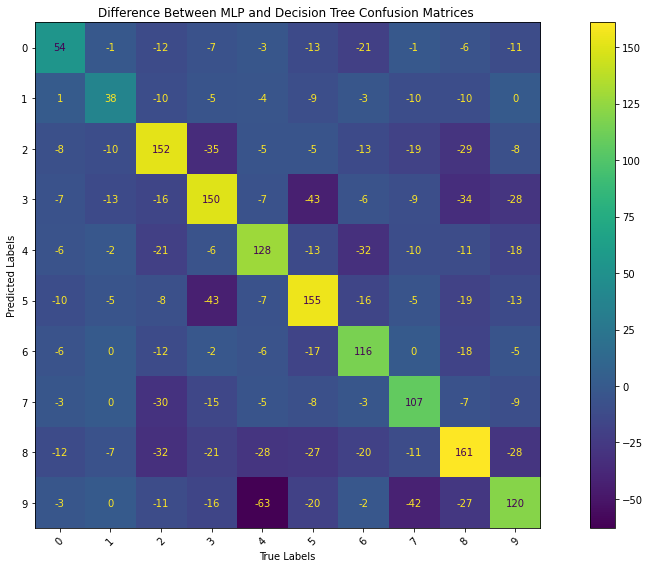

In [10]:
fig, ax = plt.subplots(figsize=(14, 8))

ConfusionMatrixDisplay(
    mlp_cf_matrix - dt_cf_matrix,
    display_labels=list(range(10))
).plot(values_format='.0f', ax=ax)

ax.set(
    title='Difference Between MLP and Decision Tree Confusion Matrices',
    xlabel='True Labels',
    ylabel='Predicted Labels'
)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()